Ordinal Patterns implementation

In [1]:
import numpy as np
import pandas as pd 
import ordpy as ord
import os
import math
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix

EVAL_DICT = {'accuracy ' : accuracy_score, "recall" : recall_score, "f1 score" : f1_score}

plt.style.use('ggplot')

In [2]:

def evaluate_model(preds, labels):
    res = {}
    for mname, metric in EVAL_DICT.items():

        if 'f1' in mname:
            res[mname] = metric(labels, preds, average='binary')

        else:
            res[mname] = metric(labels, preds)

    return res


def display_metrics(metrics):

    for mname, value in metrics.items():
        if mname != 'confusion_matrix':
            print(f"{mname}:{value:.4f}", end="\t")
        else:
            print()
            print(mname)
            print(value)

In [3]:
def recover_data_from_df(csv_path= "../data/processed/final/train_val_test", filter= False):

    data_splits = {t.split('.')[0] : t for t in os.listdir(csv_path)}
    final_data = {key : [] for key in data_splits}
    final_targets = {key : [] for key in data_splits}
    final_names = {key : [] for key in data_splits}


    for dt, dpath in data_splits.items(): 
        final_path = os.path.join(csv_path, dpath)

        for sample, df in pd.read_csv(final_path).groupby('sample'):
            
            label = df['label'].iloc[0]
            workout = df['Workout'].iloc[0]
            df.drop(columns=['sample', 'label', 'Workout'], inplace=True)

            apn_obj = df.T.values

            final_data[dt].append(apn_obj)
            final_targets[dt].append(label)
            final_names[dt].append(workout)


        final_targets[dt] = np.array(final_targets[dt])

    return final_data, final_targets, final_names

ft, fy, fn = recover_data_from_df()

In [4]:
x = ft['train_data'][0] # uma unica amostra da serie, nao tem como fazer com todas
 

def get_op_from_ts(x, dx, dy=1, taux=10):
    
    """
    Applies the Bandt and Pompe symbolization approach to obtain 
    a probability distribution of ordinal patterns (permutations) from data, adapted from ordpy.
    
    Parameters
    ----------
    data : array 
           Array object in the shape (channels, len)
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).

    """

    symbols = ord.ordinal_sequence(x, dx=dx, dy= dy, taux=taux)

    if np.shape(symbols).__len__() == 3:
        symbols = symbols.reshape(-1, dx*dy) 
    else:
        pass
    
    all_symbols            = np.asarray(list(itertools.permutations(range(dx*dy))), dtype='int')
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)
    probabilities          = symbols_count/symbols_count.sum()

    all_symbols_str       = np.apply_along_axis(np.char.strip, 0, 
                                                np.apply_along_axis(np.array2string, 1, all_symbols, separator=''),
                                                chars="[]")

    if len(probabilities)==math.factorial(dx*dy):
        # return MinMaxScaler().fit_transform(probabilities)
        return dict(zip(all_symbols_str, probabilities))
        # return (probabilities - probabilities.min()) / (probabilities.max() - probabilities.min())
    

    all_probs             = np.full(math.factorial(dx*dy), 0.)
    dict_probs = dict(zip(all_symbols_str, all_probs))

    for symbol, probability in zip(all_symbols_str, probabilities):
        dict_probs[symbol] = probability
    
    # normalizing 

    # v = MinMaxScaler().fit_transform(np.array(dict_probs.values()).reshape(-1, 1))
    # v = (v - np.min(v)) / (np.max(v) - np.min(v))
    return dict_probs

def get_op(datalist, dx, dy=1, taux =10):
    try:
        return np.array([(list(get_op_from_ts(x, dx, dy, taux=taux).values())) for x in datalist])
    except:
        return np.array([(list(get_op_from_ts(x, dx, dy, taux=taux))) for x in datalist])



dprob = get_op_from_ts(x, 5, 1)

# plt.bar(range(len(dprob)), dprob.values())


In [5]:
xtrain, xval, xtest = get_op(ft['train_data'], 2), get_op(ft['validation_data'], 2), get_op(ft['test_data'], 2)

print(xtrain.shape)
print(xval.shape)
print(xtest.shape)

(383, 2)
(107, 2)
(55, 2)


In [6]:

def loop_clfs(xtrain, xval):

    classifiers = {"5-nn" : KNeighborsClassifier(), "SVM" : SVC(), "LogReg" : LogisticRegression(), "RF" : RandomForestClassifier()}
    res = {}


    for clf, cfoo in classifiers.items():
        
        pipe = Pipeline([('scaler', MinMaxScaler()), (clf, cfoo)])

        pipe.fit(xtrain, fy['train_data'])
        pred_val = pipe.predict(xval)

        dval = evaluate_model(pred_val, labels=fy['validation_data']) 
        res[clf] = dval

    return res


def grid_search_on_OP(params):

    ans = {"5-nn" : [], "SVM" : [], "LogReg" : [], "RF" : []}
    for p in tqdm(params):
        dx, dy, taux = p['dx'], p['dy'], p['taux']
        
        xtrain = MinMaxScaler().fit_transform(get_op(ft['train_data'], dx, dy, taux))
        xval = MinMaxScaler().fit_transform(get_op(ft['validation_data'], dx, dy, taux))
        xtest = MinMaxScaler().fit_transform(get_op(ft['test_data'], dx, dy, taux))

        t = loop_clfs(xtrain, xval) # * --> dict := (clf, clf_metrics) 
        
                
        for clf, metrics in t.items():

            metrics['dx'] = dx
            metrics['dy'] = dy
            metrics['taux'] = taux

            ans[clf].append(metrics)


        # return ans
    return {key: pd.DataFrame.from_dict(v) for key, v in ans.items()}

params = ParameterGrid(
    {'dx' : [3, 4], 'dy' : [1, 2], 'taux' : [1, 10, 20] }
    # {'dx' : [2], 'dy' : [1], 'taux' : [1, 10] }

    
)


dict_ans = grid_search_on_OP(params)


        

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
for key, value in dict_ans.items():
    print(key)
    value.sort_values(by=['f1 score', 'accuracy ', 'recall'], ascending=False, inplace=True)
    display(value.head(3))

5-nn


,accuracy,recall,f1 score,dx,dy,taux
11,0.813084,0.770833,0.787234,4,2,20
10,0.822430,0.729167,0.786517,4,2,10
7,0.785047,0.812500,0.772277,4,1,10


SVM


,accuracy,recall,f1 score,dx,dy,taux
4,0.925234,0.937500,0.918367,3,2,10
5,0.897196,0.916667,0.888889,3,2,20
11,0.850467,0.875000,0.840000,4,2,20


LogReg


,accuracy,recall,f1 score,dx,dy,taux
4,0.915888,0.916667,0.907216,3,2,10
5,0.850467,0.750000,0.818182,3,2,20
10,0.803738,0.937500,0.810811,4,2,10


RF


,accuracy,recall,f1 score,dx,dy,taux
11,0.813084,0.791667,0.791667,4,2,20
5,0.813084,0.770833,0.787234,3,2,20
6,0.831776,0.666667,0.780488,4,1,1


In [ ]:
clf_param = {"5-nn" : {'dx':4, 'dy': 2,	'taux': 20} ,
             "SVM" :  {'dx':3, 'dy': 2,	'taux': 10} ,
            "LogReg": {'dx':3, 'dy': 2,	'taux': 20} ,
              "RF" :  {'dx':4, 'dy': 2,	'taux': 20} ,}


def test_best_params(param):

	classifiers = {"5-nn" : KNeighborsClassifier(), "SVM" : SVC(), "LogReg" : LogisticRegression(), "RF" : RandomForestClassifier()}
	for clfname, cfoo in classifiers.items():
		print(clfname)
		dx, dy, taux = list(param[clfname].values())
		xtest = get_op(ft['test_data'],dx, dy, taux )
		xtrain = get_op(ft['train_data'],dx, dy, taux )

		pipe = Pipeline([('scaler', MinMaxScaler()), (clfname, cfoo)])
		pipe.fit(xtrain, fy['train_data'])

		pred_test = pipe.predict(xtest)
		dval = evaluate_model(pred_test, fy['test_data'])
		display_metrics(dval)
		print()


test_best_params(clf_param)

5-nn


In [8]:
xtrain[0]

array([0.50424279, 0.49575721])

In [ ]:
def test_best_params(param):

	classifiers = {"5-nn" : KNeighborsClassifier(), "SVM" : SVC(), "LogReg" : LogisticRegression(), "RF" : RandomForestClassifier()}
	for clfname, cfoo in classifiers.items():
		print(clfname)

		xtest = get_bop(ft['test_data'], param[clfname])
		xtrain = get_bop(ft['train_data'], param[clfname])

		pipe = Pipeline([('scaler', MinMaxScaler()), (clfname, cfoo)])
		pipe.fit(xtrain, fy['train_data'])

		pred_test = pipe.predict(xtest)
		dval = evaluate_model(pred_test, fy['test_data'])
		display_metrics(dval)
		print()


test_best_params(clf_param)

In [9]:
train_ce = []

for dt in ft['train_data']:

    # entropy, complexity
    train_ce.append(ord.complexity_entropy(dt, dx=4, dy=2, taux=10))


train_ce = np.array(train_ce)

In [10]:
train_ce.shape

(383, 2)

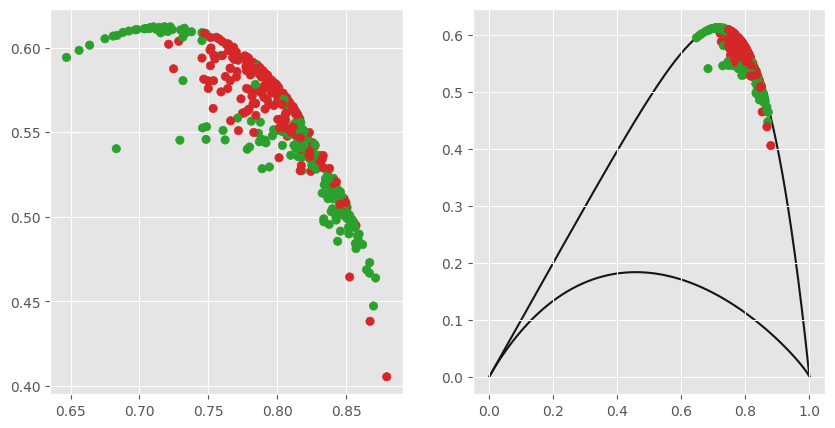

In [11]:
colors = ['tab:green' if k == 1 else 'tab:red' for k in fy['train_data']]

#theoretical curves
hc_max_curve = ord.maximum_complexity_entropy(dx=4, dy=2).T
hc_min_curve = ord.minimum_complexity_entropy(dx=4, dy=2).T

fig, axs = plt.subplots(1, 2, figsize= (10,5))

#theoretical curves
hmin, cmin = hc_min_curve  #(this variable is defined in the cell above)
hmax, cmax = hc_max_curve  #(this variable is defined in the cell above)
plt.plot(hmin, cmin, linewidth=1.5, color="#161414", zorder=0)
plt.plot(hmax, cmax, linewidth=1.5, color="#161414", zorder=0)
plt.scatter(train_ce.T[0,:], train_ce.T[1,:], c=colors)
axs[0].scatter(train_ce.T[0,:], train_ce.T[1,:], c=colors)

